# Preparation

Import Library ที่จะต้องใช้งาน

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

อ่านข้อมูลจากโฟลเดอร์ที่เก็บรูปภาพไว้

In [2]:
data_dir = pathlib.Path(r'C:\MLOps323\Project_Setup\images')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f'This Dataset have {image_count} images.')

This Dataset have 258 images.


เตรียมขนาดที่จะใช้เปลี่ยนขนาดรูปและแบ่งรูปภาพออกเป็นชุด ๆ

In [3]:
batch_size = 32
img_height = 180
img_width = 180

แปลงข้อมูลรูปภาพให้เป็น Tensor Data และแบ่งชุด Train กับ Test

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 258 files belonging to 5 classes.
Using 207 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 258 files belonging to 5 classes.
Using 51 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)
print(num_classes)

['flood', 'footpath', 'safety', 'traffic', 'trash']
5


ทดสอบเรียกดูรูปภาพในชุด Train

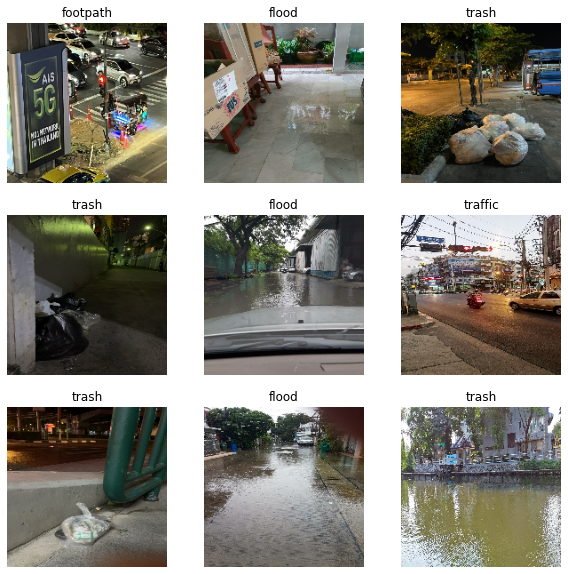

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

ตรวจสอบขนาดของข้อมูล

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


กำหนดค่าให้กับการอ่านชุดข้อมูลจาก Disk เพื่อให้การ Train มีประสิทธิภาพมากขึ้น

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create Model

In [17]:
tf.keras.backend.clear_session()

In [18]:
model = Sequential()

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [20]:
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

# model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (2, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(16, (2, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        8224      
                                                        

# Training the Model

In [23]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
7/7 [==============================] - 7s 936ms/step - loss: 1.6162 - accuracy: 0.2947 - val_loss: 1.5416 - val_accuracy: 0.2745
Epoch 2/10
7/7 [==============================] - 7s 941ms/step - loss: 1.5081 - accuracy: 0.3092 - val_loss: 1.4254 - val_accuracy: 0.4706
Epoch 3/10
7/7 [==============================] - 6s 912ms/step - loss: 1.5082 - accuracy: 0.3478 - val_loss: 1.4901 - val_accuracy: 0.5098
Epoch 4/10
7/7 [==============================] - 6s 932ms/step - loss: 1.4878 - accuracy: 0.3285 - val_loss: 1.4866 - val_accuracy: 0.5294
Epoch 5/10
7/7 [==============================] - 6s 925ms/step - loss: 1.4937 - accuracy: 0.3527 - val_loss: 1.4340 - val_accuracy: 0.4902
Epoch 6/10
7/7 [==============================] - 6s 1s/step - loss: 1.4837 - accuracy: 0.3382 - val_loss: 1.4635 - val_accuracy: 0.5882
Epoch 7/10
7/7 [==============================] - 6s 919ms/step - loss: 1.4765 - accuracy: 0.3720 - val_loss: 1.4643 - val_accuracy: 0.5882
Epoch 8/10
7/7 [=======

# Evaluate

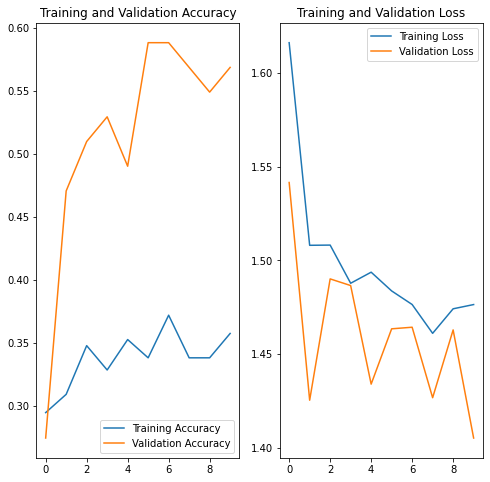

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
result = model.evaluate(val_ds, batch_size=batch_size)
print("Test Loss:", result[0])
print("Test Accuracy:", result[1])

2/2 [==============================] - 0s 100ms/step - loss: 1.4052 - accuracy: 0.5686
Test Loss: 1.4051883220672607
Test Accuracy: 0.5686274766921997


In [26]:
labels = []
for data, label in val_ds:
    labels.append(label.numpy().tolist())

In [27]:
y_test = labels[0] + labels[1]

In [28]:
predicted = model.predict(val_ds)
predicted_classes = []

for i in range(len(predicted)):
    score = tf.nn.softmax(predicted[i])
    pd_class = np.argmax(score)
    predicted_classes.append(pd_class)

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_test, predicted_classes, target_names=class_names, zero_division=False))

              precision    recall  f1-score   support

       flood       0.00      0.00      0.00         2
    footpath       0.55      0.92      0.69        24
      safety       0.64      0.47      0.54        15
     traffic       0.00      0.00      0.00         6
       trash       0.00      0.00      0.00         4

    accuracy                           0.57        51
   macro avg       0.24      0.28      0.25        51
weighted avg       0.45      0.57      0.48        51



# Test on Real Image

In [60]:
import requests
from PIL import Image
from io import BytesIO

In [62]:
batch_size = 32
img_height = 180
img_width = 180
class_names = ['flood', 'footpath', 'safety', 'traffic', 'trash']

url = 'https://www.ridebuster.com/wp-content/uploads/2018/04/Danger-road-05.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to footpath with a 24.76 percent confidence.


# Save and Load Model

In [18]:
# Save Model
saving_model = model.save('CNNsBaseline')

INFO:tensorflow:Assets written to: CNNsBaseline\assets


In [22]:
# Load Model
CNNs = keras.models.load_model('./CNNsBaseline')

In [20]:
import requests
from PIL import Image
from io import BytesIO

In [23]:
# Testing the Loaded Model

batch_size = 32
img_height = 180
img_width = 180
class_names = ['flood', 'footpath', 'safety', 'traffic', 'trash']

url = 'https://wtop.com/wp-content/uploads/2019/07/Severe_Weather_Washington_Flooding_61968-1880x1254.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = CNNs.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to footpath with a 23.65 percent confidence.
